# Environment preapration
Import libreries, define some reqire global variable.

In [ ]:
!pip install jsonlines

In [ ]:
#import libraries

import jsonlines
import json
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD
from tqdm.notebook import tqdm
from typing import *
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
#define costants

pathTrain = '/content/drive/My Drive/nlp_hw/train.jsonl'
pathDev = '/content/drive/My Drive/nlp_hw/dev.jsonl'
pathGlove= '/content/drive/My Drive/nlp_hw/glove.6B.100d.txt'
TGT = "<TGT>"
SEP = "<SEP>"

#Import of the Glove file and creation of a vocabulary from the pre-trained word embedding. 
The vocabulary will be a dictionary with words as keys and tensors as values.

In [ ]:
#read pre-trained glove model
with open(pathGlove) as f:
  w2v = f.readlines()
w2v = [i.split(maxsplit = 1) for i in w2v]

#create a vocabulary from previous pre-trained model
vocabulary = {}
tensor = torch.tensor
for w, vec in w2v:
  vec = vec[:-2] #cut '\n'
  vec2 = vec.split()
  i = 0
  vec3 = [len(vec2)]
  vec3[i] = [np.float(vec2[i]) for i in range(len(vec2))]
  tensor = torch.tensor(vec3)
  vocabulary.update({w:tensor})

In [ ]:
#save the vocabulary created trough glove
torch.save(vocabulary,'/content/drive/My Drive/nlp_hw/vocabulary.txt')

# Implementation of functions for reading, organization and elaboration of data from dataset

In [ ]:
#organization of dataset

def organize_dataset(path: str):

  data = jsonlines.open(path)
  sentences = []
  new_sentences = []
  labels = []
  target_word = []

  for line in data:

    # first sentence of dataset
    sentence1 = line['sentence1']
    sentence1 = sentence1[0:np.int(line['start1'])-1]+" "+TGT+sentence1[np.int(line['end1']):]
    sentence1 = ''.join( c for c in sentence1 if c not in string.punctuation) #remove punctuation from words

    #second sentence of dataset
    sentence2 = line['sentence2']
    sentence2 = sentence2[0:np.int(line['start2'])-1]+" "+TGT+sentence2[np.int(line['end2']):]
    sentence2 = ''.join( c for c in sentence2 if c not in string.punctuation) #remove punctuation from words

    #concatenate sentences with format "....<TGT>.....<SEP>.....<TGT>...."
    sentences.append(sentence1+" "+SEP+" "+sentence2)

    #save labels
    labels.append(line['label'])

    #save target word
    target_word.append(line['lemma'])

  #create a list of words from sentence
  for s in sentences:
    new_sentences.append(s.split(" ")) 

  assert len(new_sentences) == len(labels) 
  
  #return dataset with form (['word1',...,'wordN'],'True')
  return new_sentences, labels

In [ ]:
#transformation of words in tensors using previos vocabulary

def VecFromWord(voc: dict, sentences: list):

  new_sentences = []
  
  #for each sentence split the two different sentences of dataset
  #and tranform evry word in the corrispective tensors given by pre-trained model
  for s in sentences:

    split_id = s.index(SEP)
    s1 = s[:split_id]
    s2 = s[split_id+1:]
    vecs1 = transform(voc,s1)
    vecs2 = transform(voc,s2)

    new_sentence = []
    new_sentence.append(vecs1)
    new_sentence.append(vecs2)

    # form: [[tensor1_1,....,tensor1_N],[tensor2_1,.....,tensor2_N]]
    new_sentences.append(new_sentence)

  return new_sentences

#function for effective transormation
def transform(v: dict, l: list):

  vec = []
  miss = []

  for word in l:
    word = word.lower()
    if word in v.keys():
      vec.append(v[word])
    elif word != SEP and word != TGT:
      miss.append(word)

  '''management of miss words: each missing word will be replaced
     with the average of other words'''
  sum = 0
  for i in vec:
    sum += i
  sum = sum/len(vec)
  for _ in range(len(miss)):
    vec.append(sum)

  '''management of target words: they will be tensors with all ones
     added one time because there is one target word for each sentence'''
  vec.append(torch.zeros(100))

  return vec

In [ ]:
#organizazion of data for input of a classification model

def aggregation(data: list):

  new_data = []

  for d in data:

    sum1 = 0
    for el in d[0]:
      sum1+= el
    sum1 = sum1/len(d[0])
  
    sum2 = 0
    for el in d[1]:
      sum2+=el
    sum2 = sum2/len(d[1])

    #form: [tensor1,.......,tensorN], 
            # with tensor_i = [tensor1_1,....,tensor1_N] - [tensor2_1,......,tensor2_N]
    new_data.append(sum1-sum2)

  return new_data

def transform_label(y: list):

  new_y = [] 

  for i in y:
    if i == 'True':
      new_y.append(torch.ones(1))
    else:
      new_y.append(torch.zeros(1))
     
  return new_y

# Implementation of model classifier and its functions

In [ ]:
#classification model

class SentenceClassifier(torch.nn.Module):

    def __init__(self, n_features: int):
        super().__init__()
        self.layerIn = torch.nn.Linear(n_features, 100)
        self.hidden1 = torch.nn.Linear(100, 50)
        self.hidden2 = torch.nn.Linear(50, 10)
        self.layerOut = torch.nn.Linear(10, 1)
        self.loss_fn = torch.nn.BCELoss()

    def forward(self, x: torch.Tensor, y: Optional[torch.Tensor] = None) -> Dict[str, torch.Tensor]:
        
        out = self.layerIn(x)
        out = torch.relu(out)
        out = self.hidden1(out)
        out = torch.relu(out)
        out = self.hidden2(out)
        out = torch.relu(out)
        out = self.layerOut(out).squeeze(1)
        out = torch.sigmoid(out)

        result = {'pred': out}

        if y is not None:
            loss = self.loss_fn(out, y)
            result['loss'] = loss

        return result

In [ ]:
def train(model: nn.Module, optimizer: torch.optim.Optimizer, data_train: DataLoader, data_val:DataLoader, epochs: int):

    train_loss = []
    val_loss = []

    train_acc = []
    val_acc = []

    for epoch in range(epochs):

        print("\nepoch: "+np.str(epoch)+":")


        # batches of the training set
        tot_loss = []
        dim_set = 0
        num_true = 0
        for x, y in data_train:

          optimizer.zero_grad()
          data_out = model(x, y)
          loss = data_out['loss']

          pred = torch.round(data_out['pred'])
          dim_set += pred.shape[0]
          num_true += (y == pred).int().sum()

          tot_loss.append(loss.item())

          loss.backward()
          optimizer.step()

        el_acc =(num_true/dim_set).item()
        train_acc.append(el_acc)
        el_loss = sum(tot_loss)/len(tot_loss)
        train_loss.append(el_loss)
        print("Train Loss: "+np.str(el_loss)+" - Train Accuracy: "+np.str(el_acc))

        #batches of the validation set
        tot_loss = []
        dim_set = 0
        num_true = 0
        for x,y in data_val:

          data_out = model(x)
          pred = torch.round(data_out['pred'])

          data_out = model(x, y)
          loss = data_out['loss']

          pred = torch.round(data_out['pred'])
          dim_set += pred.shape[0]
          num_true += (y == pred).int().sum()

          tot_loss.append(loss.item())
  
        el_acc =(num_true/dim_set).item()
        val_acc.append(el_acc)
        el_loss = sum(tot_loss)/len(tot_loss)
        val_loss.append(el_loss)
        print("Validation Loss: "+np.str(el_loss)+" - Validation Accuracy: "+np.str(el_acc)+"\n")

    return train_loss, val_loss, train_acc, val_acc

In [ ]:
def test(model: nn.Module, dataloader: DataLoader):

  num_true = 0
  dim_set = 0

  pred_array = np.array([])
  y_array = np.array([])

  for x, y in dataloader:
        
    data_out = model(x)
    pred = data_out['pred']

    pred = torch.round(pred)
    dim_set += pred.shape[0]
    num_true += (y == pred).int().sum()

    pred_array = np.append(pred_array, [i.item() for i in pred.detach().numpy()])
    y_array = np.append(y_array, [i.item() for i in y.detach().numpy()])

  print(f'# accuracy: {(num_true / dim_set).item():.2f}')

  return pred_array, y_array

In [ ]:
#try of the predictions
def predict(model: torch.nn.Module, x: torch.Tensor) -> List[str]:

    label = []

    for i in x:
      batch_out = model(i)
      pred = torch.round(batch_out['pred'])
      pred = pred[0].item()
      if pred == 1:
        label.append('True')
      else:
        label.append('False')

    return label

# Implemenation of functions to print trend of training and testing

In [ ]:
def plot_train_trend(train_loss: list, validation_loss: list, title: str):

  plt.plot(range(len(train_loss)),train_loss)
  plt.plot(range(len(validation_loss)),validation_loss)
  plt.title(title)
  plt.xlabel('Epochs')
  plt.ylabel(title)
  plt.legend(['Train loss', 'Validation loss'], loc='upper left')
  plt.show

In [ ]:
def plot_confusion_matrix(y: np.array, pred: np.array, classes: list):

  print('Confusion Matrix')
  cm = confusion_matrix(y, pred)
  classes = ['True','False']
  fig, ax = plt.subplots()
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  ax.figure.colorbar(im, ax=ax)
  ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=classes, yticklabels=classes,
           title='Test set',
           ylabel='True label',
           xlabel='Predicted label')
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center")
  fig.tight_layout()

In [ ]:
def plot_classification_report(y: np.array, pred: np.array, classes: list):

  print('Classification Report')
  print(classification_report(y, pred, target_names=classes))

# Execution of functions
Take data, define and train model

In [ ]:
#read data

x_train, y_train = organize_dataset(pathTrain)
x_test, y_test = organize_dataset(pathDev)

In [ ]:
#trasformation of words in vectors

x_train = VecFromWord(vocabulary, x_train)
x_test = VecFromWord(vocabulary, x_test)

In [ ]:
#final elaboration of data

x_train = aggregation(x_train)
y_train = transform_label(y_train)

x_test = aggregation(x_test)
y_test = transform_label(y_test)

In [ ]:
#split training set into train and validation to train and to value the model
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 43)

In [ ]:
#re-compute final dataset

dataset = []
dataset = [(x,y) for x,y in zip(x_train,y_train)]
train_data = DataLoader(dataset, batch_size=64)

dataset = []
dataset = [(x,y) for x,y in zip(x_val,y_val)]
validation_data = DataLoader(dataset, batch_size=64)

dataset = []
dataset = [(x,y) for x,y in zip(x_test,y_test)]
test_data = DataLoader(dataset, batch_size=64)

In [ ]:
#shape of a tensor of a genric word
features = x_train[0].shape[1]

#Model 1


*   Data elaboration: **Difference** between tensors of two sentences, each tensor is the average of tensors of each word.
*   2 hidden layer [(100,50) -> (50,30) -> (30,10) -> (10,1)]
*  **250** epochs
*   SGD Optimizer with learning rate = 0.01





In [ ]:
#defination model and opitmizer

model = SentenceClassifier(features)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [ ]:
#training loop
train_loss, val_loss, train_acc, val_acc = train(model,optimizer,train_data,validation_data,250)


epoch: 0:
Train Loss: 0.6340227829085456 - Train Accuracy: 0.652430534362793
Validation Loss: 0.6528731882572174 - Validation Accuracy: 0.6078125238418579


epoch: 1:
Train Loss: 0.6324471076329549 - Train Accuracy: 0.6534722447395325
Validation Loss: 0.6520698010921478 - Validation Accuracy: 0.6078125238418579


epoch: 2:
Train Loss: 0.6308786577648586 - Train Accuracy: 0.6539930701255798
Validation Loss: 0.6513124883174897 - Validation Accuracy: 0.6078125238418579


epoch: 3:
Train Loss: 0.629314187500212 - Train Accuracy: 0.6565971970558167
Validation Loss: 0.6505888402462006 - Validation Accuracy: 0.604687511920929


epoch: 4:
Train Loss: 0.6277629799313016 - Train Accuracy: 0.6586805582046509
Validation Loss: 0.6498904585838318 - Validation Accuracy: 0.606249988079071


epoch: 5:
Train Loss: 0.6262148347165849 - Train Accuracy: 0.6586805582046509
Validation Loss: 0.6492144465446472 - Validation Accuracy: 0.609375


epoch: 6:
Train Loss: 0.6246810124980079 - Train Accuracy: 0.6621

In [ ]:
#test

pred, y  = test(model, test_data)

# accuracy: 0.67


In [ ]:
#save the weights model
torch.save(model, "/content/drive/My Drive/nlp_hw/model.pt", pickle_protocol=4)

 Plotting trends of Loss and Accuracy of the model during training

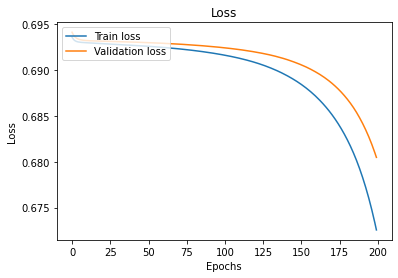

In [ ]:
plot_train_trend(train_loss,val_loss,'Loss')

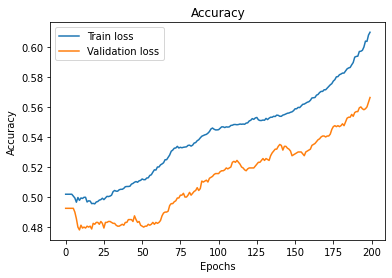

In [ ]:
plot_train_trend(train_acc,val_acc,'Accuracy')

Confusion Matrix


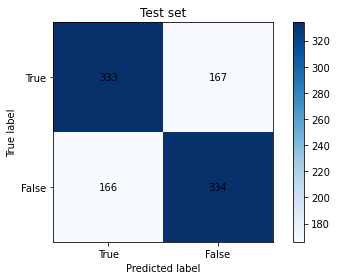

In [ ]:
plot_confusion_matrix(y,pred,['True','False'])

In [ ]:
plot_classification_report(y,pred,['True','False'])

Classification Report
              precision    recall  f1-score   support

        True       0.67      0.67      0.67       500
       False       0.67      0.67      0.67       500

    accuracy                           0.67      1000
   macro avg       0.67      0.67      0.67      1000
weighted avg       0.67      0.67      0.67      1000



#Model 2

*   Data elaboration: **Sum** between tensors of two sentences, each tensor is the average of tensors of each word.
*   2 hidden layer [(100,50) -> (50,30) -> (30,10) -> (10,1)]
*   **250** epochs
*   SGD Optimizer with learning rate = 0.01

In [ ]:
#defination model and opitmizer

model2 = SentenceClassifier(features)
optimizer = torch.optim.SGD(model2.parameters(), lr=0.01)

In [ ]:
#training loop
train_loss, val_loss, train_acc, val_acc = train(model2,optimizer,train_data,validation_data,250)


epoch: 0:
Train Loss: 0.7014888662099839 - Train Accuracy: 0.5018749833106995
Validation Loss: 0.7002196621894836 - Validation Accuracy: 0.4925000071525574


epoch: 1:
Train Loss: 0.6966385126113892 - Train Accuracy: 0.5018749833106995
Validation Loss: 0.6966385388374329 - Validation Accuracy: 0.4925000071525574


epoch: 2:
Train Loss: 0.6946127456426621 - Train Accuracy: 0.5018749833106995
Validation Loss: 0.6950036787986755 - Validation Accuracy: 0.4925000071525574


epoch: 3:
Train Loss: 0.6937634009122848 - Train Accuracy: 0.5018749833106995
Validation Loss: 0.6942335557937622 - Validation Accuracy: 0.4925000071525574


epoch: 4:
Train Loss: 0.6934082645177841 - Train Accuracy: 0.5018749833106995
Validation Loss: 0.6938480854034423 - Validation Accuracy: 0.4925000071525574


epoch: 5:
Train Loss: 0.6932502073049546 - Train Accuracy: 0.5018749833106995
Validation Loss: 0.6936373066902161 - Validation Accuracy: 0.4925000071525574


epoch: 6:
Train Loss: 0.6931730264425278 - Train Ac

In [ ]:
#test

pred, y  = test(model2, test_data)

# accuracy: 0.56


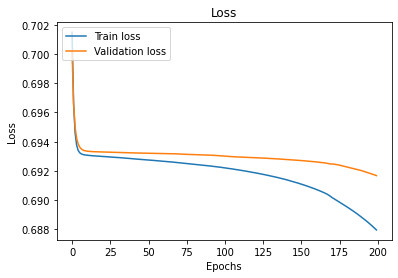

In [ ]:
plot_train_trend(train_loss,val_loss,'Loss')

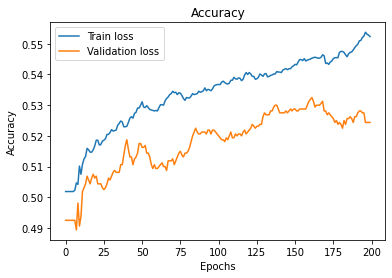

In [ ]:
plot_train_trend(train_acc,val_acc,'Accuracy')

Confusion Matrix


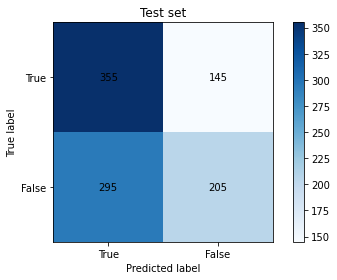

In [ ]:
plot_confusion_matrix(y,pred,['True','False'])

In [ ]:
plot_classification_report(y,pred,['True','False'])

Classification Report
              precision    recall  f1-score   support

        True       0.55      0.71      0.62       500
       False       0.59      0.41      0.48       500

    accuracy                           0.56      1000
   macro avg       0.57      0.56      0.55      1000
weighted avg       0.57      0.56      0.55      1000



# Model 3

*   Data elaboration: **Difference** between tensors of two sentences, each tensor is the average of tensors of each word.
*   2 hidden layer [(100,50) -> (50,30) -> (30,10) -> (10,1)]
*   **500** epochs
*   SGD Optimizer with learning rate = 0.01

In [ ]:
#defination model and opitmizer

model3 = SentenceClassifier(features)
optimizer = torch.optim.SGD(model3.parameters(), lr=0.01)

In [ ]:
#training loop
train_loss, val_loss, train_acc, val_acc = train(model3,optimizer,train_data,validation_data,500)


epoch: 0:
Train Loss: 0.6925717121362687 - Train Accuracy: 0.5212500095367432
Validation Loss: 0.6926480937004089 - Validation Accuracy: 0.4962500035762787


epoch: 1:
Train Loss: 0.6925557047128678 - Train Accuracy: 0.5215625166893005
Validation Loss: 0.6926340961456299 - Validation Accuracy: 0.4975000023841858


epoch: 2:
Train Loss: 0.6925394529104233 - Train Accuracy: 0.5228124856948853
Validation Loss: 0.6926201128959656 - Validation Accuracy: 0.4987500011920929


epoch: 3:
Train Loss: 0.6925227665901184 - Train Accuracy: 0.5246875286102295
Validation Loss: 0.6926058983802795 - Validation Accuracy: 0.49812498688697815


epoch: 4:
Train Loss: 0.6925057274103165 - Train Accuracy: 0.5256249904632568
Validation Loss: 0.6925913977622986 - Validation Accuracy: 0.5


epoch: 5:
Train Loss: 0.6924885928630828 - Train Accuracy: 0.5264062285423279
Validation Loss: 0.6925767159461975 - Validation Accuracy: 0.5037500262260437


epoch: 6:
Train Loss: 0.6924712765216827 - Train Accuracy: 0.5254

In [ ]:
#test

pred, y  = test(model3, test_data)

# accuracy: 0.62


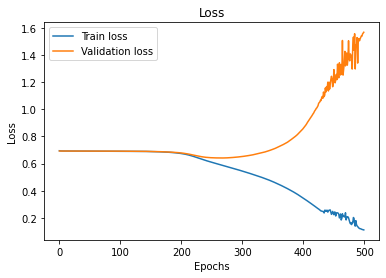

In [ ]:
plot_train_trend(train_loss,val_loss,'Loss')

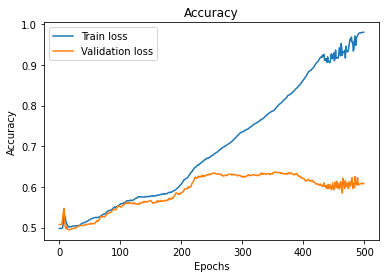

In [ ]:
plot_train_trend(train_acc,val_acc,'Accuracy')

Confusion Matrix


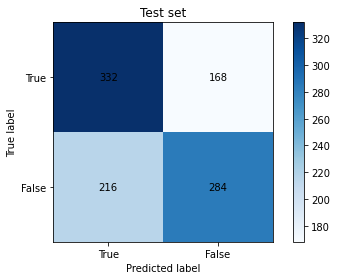

In [ ]:
plot_confusion_matrix(y,pred,['True','False'])

In [ ]:
plot_classification_report(y,pred,['True','False'])

Classification Report
              precision    recall  f1-score   support

        True       0.61      0.66      0.63       500
       False       0.63      0.57      0.60       500

    accuracy                           0.62      1000
   macro avg       0.62      0.62      0.62      1000
weighted avg       0.62      0.62      0.62      1000



#Model 4

*   Data elaboration: **sum** between tensors of two sentences, each tensor is the **sum** of tensors of each word.
*   2 hidden layer [(100,50) -> (50,30) -> (30,10) -> (10,1)]
*   **250** epochs
*   SGD Optimizer with learning rate = 0.01

In [ ]:
#defination model and opitmizer

model4 = SentenceClassifier(features)
optimizer = torch.optim.SGD(model4.parameters(), lr=0.01)

In [ ]:
#training loop
train_loss, val_loss, train_acc, val_acc = train(model4,optimizer,train_data,validation_data,250)


epoch: 0:
Train Loss: 0.6940972182603009 - Train Accuracy: 0.4984722137451172
Validation Loss: 0.6922437044290396 - Validation Accuracy: 0.5137500166893005


epoch: 1:
Train Loss: 0.69227610436161 - Train Accuracy: 0.5093055367469788
Validation Loss: 0.6923635922945462 - Validation Accuracy: 0.5037500262260437


epoch: 2:
Train Loss: 0.6912204533551647 - Train Accuracy: 0.5168055295944214
Validation Loss: 0.6925236720305222 - Validation Accuracy: 0.5087500214576721


epoch: 3:
Train Loss: 0.6906017581973456 - Train Accuracy: 0.519861102104187
Validation Loss: 0.692587687419011 - Validation Accuracy: 0.5024999976158142


epoch: 4:
Train Loss: 0.6899236672747452 - Train Accuracy: 0.5236111283302307
Validation Loss: 0.6925322413444519 - Validation Accuracy: 0.5162500143051147


epoch: 5:
Train Loss: 0.6892590253754 - Train Accuracy: 0.5329166650772095
Validation Loss: 0.6918675303459167 - Validation Accuracy: 0.5224999785423279


epoch: 6:
Train Loss: 0.6882925940825876 - Train Accuracy:

In [ ]:
#test

pred, y  = test(model4, test_data)

# accuracy: 0.56


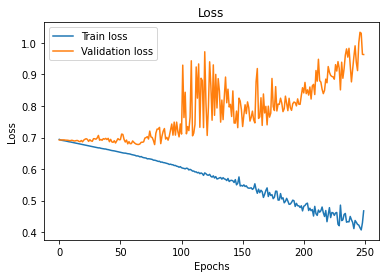

In [ ]:
plot_train_trend(train_loss,val_loss,'Loss')

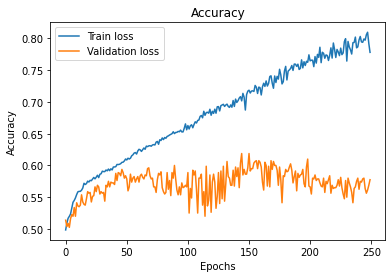

In [ ]:
plot_train_trend(train_acc,val_acc,'Accuracy')

Confusion Matrix


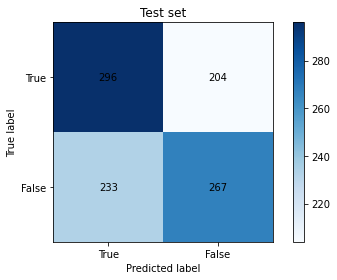

In [ ]:
plot_confusion_matrix(y,pred,['True','False'])

In [ ]:
plot_classification_report(y,pred,['True','False'])

Classification Report
              precision    recall  f1-score   support

        True       0.56      0.59      0.58       500
       False       0.57      0.53      0.55       500

    accuracy                           0.56      1000
   macro avg       0.56      0.56      0.56      1000
weighted avg       0.56      0.56      0.56      1000

